# Problem setting: Sine Wave Prediction.

This jupyter notebook demonstrates the function of **Attention Encoder/Decoder based on LSTM**.

In this demonstration, the training dataset is generated as follows.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from logging import getLogger, StreamHandler, NullHandler, DEBUG, ERROR

logger = getLogger("pydbm")
handler = StreamHandler()
handler.setLevel(ERROR)
logger.setLevel(ERROR)
logger.addHandler(handler)


In [3]:
def generate_sin(amp=0.5, sampling_freq=8000, freq=440, sec=5, extract_n=100):
    sin_list = []
    for n in np.arange(sampling_freq * sec):
        sin = amp * np.sin(2.0 * np.pi * freq * n / sampling_freq)
        sin_list.append(sin)
        if len(sin_list) > extract_n:
            break
    return np.array(sin_list[:extract_n])


In [4]:
generate_sin(freq=200).shape

(100,)

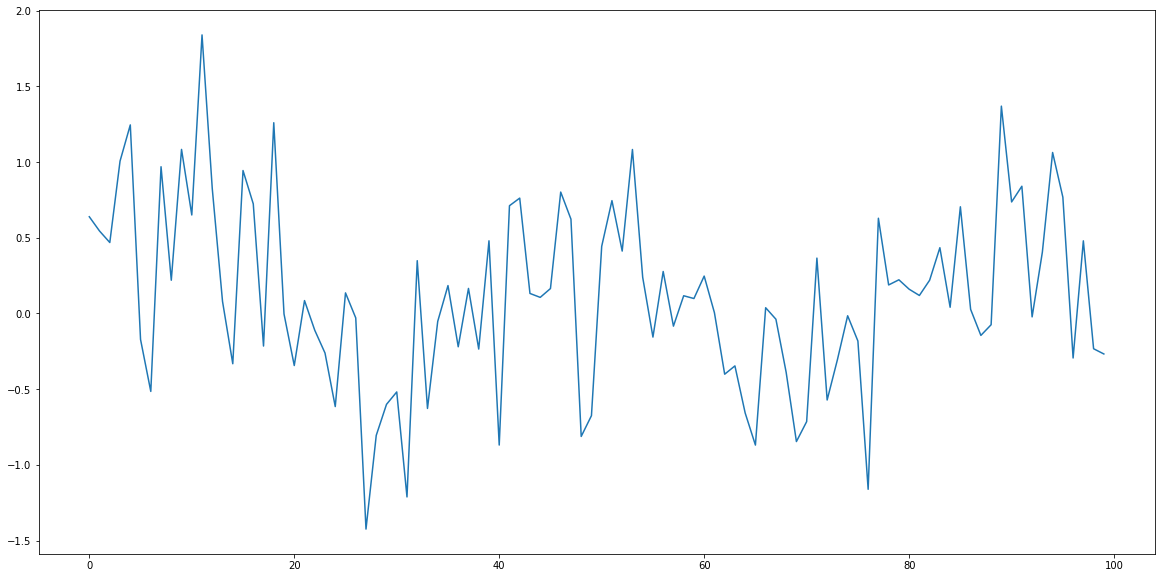

In [5]:
fig = plt.figure(figsize=(20, 10))
plt.plot(generate_sin(freq=200) + np.random.normal(loc=0.0, scale=0.5, size=100))
plt.show()

In [6]:
# The number of sampled data.
sample_n = 1000
# The length of one cycle.
cycle_len = 20
# The number of features.
feature_n = 20

# The list of observed data points.
observed_arr_list = []
# The list of objective data.
target_arr_list = []

label_list = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
test_size = 0.3

for i in range(sample_n):
    f_list = []
    t_list = []
    label_n = np.random.randint(low=0, high=len(label_list))

    for j in range(feature_n):
        sin_arr = generate_sin(freq=int(label_list[label_n]), extract_n=cycle_len)
        noise_arr = np.random.normal(loc=0.0, scale=1.5, size=cycle_len)
        sin_arr += noise_arr
        f_arr = sin_arr[:int(sin_arr.shape[0] * (1 - test_size))]
        t_arr = sin_arr[int(sin_arr.shape[0] * (1 - test_size)):]
        f_list.append(f_arr)
        t_list.append(t_arr)

    observed_arr_list.append(f_list)
    target_arr_list.append(t_list)

observed_arr = np.array(observed_arr_list)
observed_arr = (observed_arr - observed_arr.min()) / (observed_arr.max() - observed_arr.min())
observed_arr.shape

(1000, 20, 14)

All Sine waves have been added randomly generated gussain signal noise.

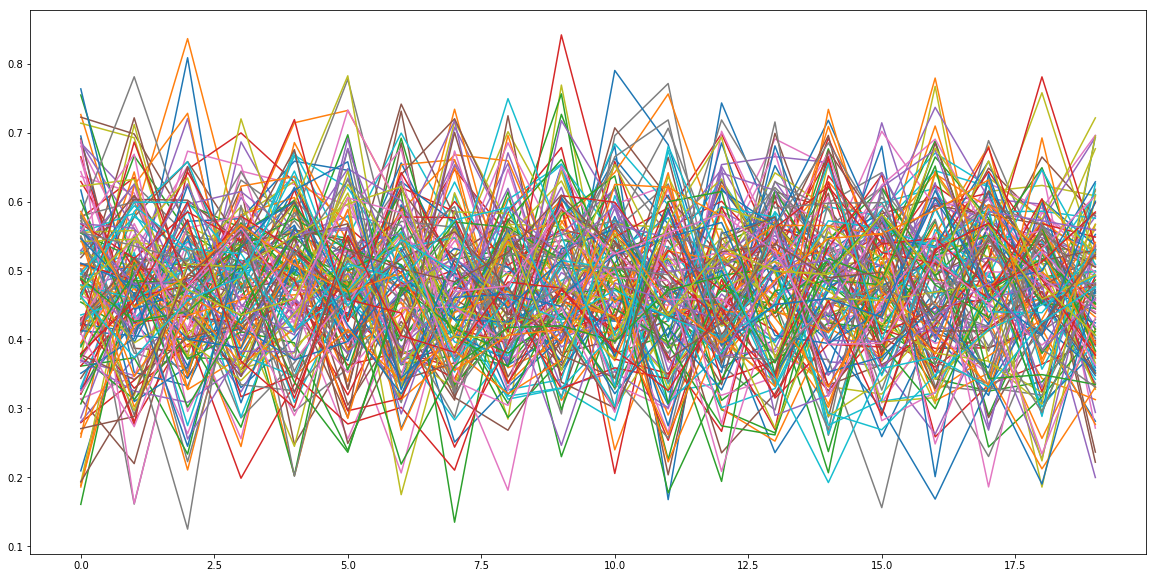

In [7]:
fig = plt.figure(figsize=(20, 10))
for i in range(10):
    plt.plot(observed_arr[i])
plt.show();plt.close()

## Problem solution: Encoder/Decoder based on LSTM.

In [8]:
# LSTM Graph which is-a `Synapse`.
from pydbm.synapse.recurrenttemporalgraph.lstm_graph import LSTMGraph
# Polymorphism.
from pydbm.synapse.recurrenttemporalgraph.lstm_graph import LSTMGraph as EncoderGraph
from pydbm.synapse.recurrenttemporalgraph.lstmgraph.attention_lstm_graph import AttentionLSTMGraph as DecoderGraph

# Loss function.
from pydbm.loss.mean_squared_error import MeanSquaredError
# SGD as a Loss function.
from pydbm.optimization.optparams.sgd import SGD
# Adam as a Loss function.
from pydbm.optimization.optparams.adam import Adam as EncoderAdam
from pydbm.optimization.optparams.adam import Adam as DecoderAdam
# Verification.
from pydbm.verification.verificate_function_approximation import VerificateFunctionApproximation
# LSTM model.
from pydbm.rnn.lstm_model import LSTMModel
# Polymorphism.
from pydbm.rnn.lstm_model import LSTMModel as Encoder
from pydbm.rnn.lstmmodel.attention_lstm_model import AttentionLSTMModel as Decoder
# Logistic Function as activation function.
from pydbm.activation.logistic_function import LogisticFunction
# Tanh Function as activation function.
from pydbm.activation.tanh_function import TanhFunction
# Identity Function as activation function.
from pydbm.activation.identity_function import IdentityFunction
# Encoder/Decoder
from pydbm.rnn.encoder_decoder_controller import EncoderDecoderController

from pydbm.optimization.batch_norm import BatchNorm

In [9]:
# Init.
encoder_graph = EncoderGraph()

# Activation function in LSTM.
encoder_graph.observed_activating_function = TanhFunction()
encoder_graph.input_gate_activating_function = LogisticFunction()
encoder_graph.forget_gate_activating_function = LogisticFunction()
encoder_graph.output_gate_activating_function = LogisticFunction()
encoder_graph.hidden_activating_function = TanhFunction()
encoder_graph.hidden_activating_function.batch_norm = BatchNorm()
encoder_graph.output_activating_function = TanhFunction()

# Initialization strategy.
# This method initialize each weight matrices and biases in Gaussian distribution: `np.random.normal(size=hoge) * 0.01`.
encoder_graph.create_rnn_cells(
    input_neuron_count=observed_arr.shape[-1],
    hidden_neuron_count=200,
    output_neuron_count=1
)

In [10]:
# Init.
decoder_graph = DecoderGraph()

# Activation function in LSTM.
decoder_graph.observed_activating_function = TanhFunction()
decoder_graph.input_gate_activating_function = LogisticFunction()
decoder_graph.forget_gate_activating_function = LogisticFunction()
decoder_graph.output_gate_activating_function = LogisticFunction()
decoder_graph.hidden_activating_function = LogisticFunction()
decoder_graph.hidden_activating_function.batch_norm = BatchNorm()
decoder_graph.output_activating_function = LogisticFunction()

# Initialization strategy.
# This method initialize each weight matrices and biases in Gaussian distribution: `np.random.normal(size=hoge) * 0.01`.
decoder_graph.create_rnn_cells(
    input_neuron_count=200,
    hidden_neuron_count=200,
    output_neuron_count=observed_arr.shape[-1]
)

In [11]:
encoder_opt_params = EncoderAdam()
encoder_opt_params.weight_limit = 0.5
encoder_opt_params.dropout_rate = 0.5

encoder = Encoder(
    # Delegate `graph` to `LSTMModel`.
    graph=encoder_graph,
    # Refereed maxinum step `t` in BPTT. If `0`, this class referes all past data in BPTT.
    bptt_tau=cycle_len,
    # Loss function.
    computable_loss=MeanSquaredError(),
    # Optimizer.
    opt_params=encoder_opt_params,
    # Verification function.
    verificatable_result=VerificateFunctionApproximation(),
    tol=0.0
)

In [12]:
decoder_opt_params = DecoderAdam()
decoder_opt_params.weight_limit = 0.5
decoder_opt_params.dropout_rate = 0.5

decoder = Decoder(
    # Delegate `graph` to `LSTMModel`.
    graph=decoder_graph,
    seq_len=observed_arr.shape[1],
    # Refereed maxinum step `t` in BPTT. If `0`, this class referes all past data in BPTT.
    bptt_tau=cycle_len,
    # Loss function.
    computable_loss=MeanSquaredError(),
    # Optimizer.
    opt_params=decoder_opt_params,
    # Verification function.
    verificatable_result=VerificateFunctionApproximation(),
    tol=0.0
)

In [13]:
encoder_decoder_controller = EncoderDecoderController(
    encoder=encoder,
    decoder=decoder,
    epochs=300,
    batch_size=10,
    learning_rate=1e-08,
    learning_attenuate_rate=0.1,
    attenuate_epoch=50,
    test_size_rate=0.3,
    computable_loss=MeanSquaredError(),
    verificatable_result=VerificateFunctionApproximation(),
    tol=0.0
)

In [14]:
# Learning.
encoder_decoder_controller.learn(observed_arr, observed_arr)

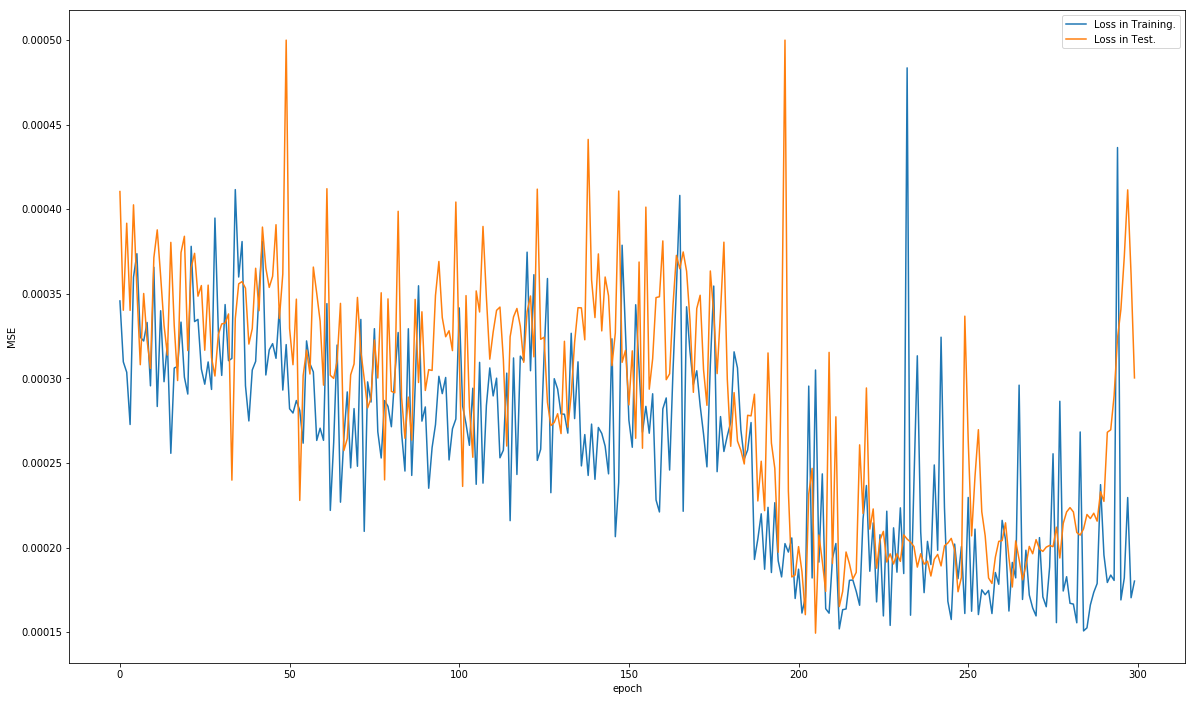

In [21]:
# Logging the loss.
fig = plt.figure(figsize=(20, 12))
plt.ylabel("MSE")
plt.xlabel("epoch")
plt.plot(encoder_decoder_controller.verificatable_result.logs_df.train_loss.values, label="Loss in Training.")
plt.plot(encoder_decoder_controller.verificatable_result.logs_df.test_loss.values, label="Loss in Test.")
plt.legend()
plt.show();plt.close()

In [16]:
encoder_decoder_controller.verificatable_result.logs_df.tail(10)

,train_loss,test_loss
290,0.000196,0.000227
291,0.000179,0.000268
292,0.000184,0.000270
293,0.000181,0.000290
294,0.000436,0.000324
295,0.000169,0.000341
296,0.000182,0.000372
297,0.000230,0.000411
298,0.000170,0.000361
299,0.000180,0.000300


In [22]:
encoder_decoder_controller.encoder.graph.hidden_activating_function.batch_norm.beta_arr

array([[[-2.44029918e-03,  1.71347796e-02,  2.69526075e-04, ...,
          1.63540635e-02,  6.27815299e-03, -2.60340040e-03]],

       [[-3.85357886e-03,  3.14647160e-03, -4.47092118e-03, ...,
          1.81826711e-03, -1.33723392e-02, -3.46146587e-03]],

       [[-1.24867322e-03, -2.28371181e-03, -1.35836484e-02, ...,
          4.92643507e-05,  1.23746593e-02, -1.67439917e-03]],

       ...,

       [[ 4.76750625e-03, -1.36527735e-02,  6.83358937e-03, ...,
         -1.16934756e-02, -1.52586491e-02,  5.43028176e-03]],

       [[ 2.42062228e-03,  1.88971654e-04, -5.17062542e-03, ...,
         -4.57125002e-03, -5.42587000e-03,  5.30920443e-04]],

       [[ 2.26042546e-03,  7.25880065e-04,  1.96641204e-03, ...,
         -7.01081855e-03, -1.26179260e-02, -1.45192368e-03]]])

In [23]:
encoder_decoder_controller.encoder.graph.hidden_activating_function.batch_norm.gamma_arr

array([[[0.99250603, 1.03223095, 0.9476952 , ..., 1.05682175,
         0.95626682, 0.97242944]],

       [[0.99898035, 1.00335057, 0.98798209, ..., 1.01457678,
         0.98901382, 0.99649464]],

       [[0.99668978, 1.00121962, 1.00158446, ..., 0.99635796,
         1.0017516 , 1.00139557]],

       ...,

       [[1.0092843 , 0.9850026 , 1.01646899, ..., 0.98508394,
         1.01619548, 1.01565144]],

       [[0.99292573, 1.00397863, 0.99491148, ..., 1.0075616 ,
         0.99656043, 0.99616457]],

       [[1.00725831, 0.99216257, 1.00601452, ..., 0.99245562,
         1.0046059 , 1.00745061]]])

In [24]:
encoder_decoder_controller.decoder.graph.hidden_activating_function.batch_norm.beta_arr

array([[[ 0.01824976,  0.01759595,  0.01795447, ...,  0.01821327,
          0.01775913,  0.01798501]],

       [[-0.01384351, -0.01772432, -0.0158171 , ..., -0.01656478,
         -0.016586  , -0.01734593]],

       [[ 0.00347695, -0.00025951,  0.00169173, ...,  0.00154629,
          0.00114053, -0.00113038]],

       ...,

       [[-0.02763596, -0.01949959, -0.02563296, ..., -0.02515481,
         -0.01938075, -0.02001467]],

       [[ 0.00626409,  0.00578152,  0.00617541, ...,  0.0060725 ,
          0.00574282,  0.00610158]],

       [[ 0.0115795 ,  0.01438107,  0.01302432, ...,  0.01428487,
          0.01404345,  0.0146544 ]]])

In [25]:
encoder_decoder_controller.decoder.graph.hidden_activating_function.batch_norm.gamma_arr

array([[[1.03596343, 1.03706729, 1.03145684, ..., 1.0336429 ,
         1.03699654, 1.0377145 ]],

       [[1.01447018, 1.01708466, 1.01306677, ..., 1.01496985,
         1.01493384, 1.016366  ]],

       [[0.99748623, 0.99771203, 0.99789497, ..., 0.997763  ,
         0.99777319, 0.99794807]],

       ...,

       [[1.00945391, 1.01238034, 1.00940211, ..., 1.01067256,
         1.0122499 , 1.01194223]],

       [[1.01675825, 1.01536584, 1.01467206, ..., 1.01500185,
         1.0117307 , 1.01297411]],

       [[1.02659462, 1.03334756, 1.03055961, ..., 1.02833188,
         1.03079387, 1.03003239]]])

# References

- Bahdanau, D., Cho, K., & Bengio, Y. (2014). Neural machine translation by jointly learning to align and translate. arXiv preprint arXiv:1409.0473.
- Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017). Attention is all you need. In Advances in Neural Information Processing Systems (pp. 5998-6008).